In [4]:
import arviz as az
import os.path as op
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

session = '3t2'
bids_folder = '/data/ds-risk'

risk_preferences = pd.read_csv(op.join(bids_folder, 'derivatives', 'cogmodels', 'simple_risk_preference.tsv'), index_col=[0, 1], sep='\t')
sns.set_theme('paper', 'white', font='helvetica', font_scale=1.25, palette='tab10')

colors = {'risk-neutral':'k', 'risk-seeking':sns.color_palette('Spectral', 5)[0], 
          'risk-averse':sns.color_palette('Spectral', 5)[-1]}

# 3T

In [13]:
idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', f'ses-{session}_model-1_trace.netcdf'))

## Evidence SD

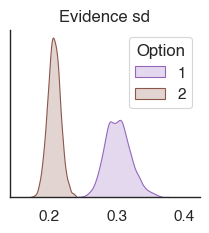

In [14]:
evidence_sd = pd.concat((idata.posterior['n1_evidence_sd_mu'].to_dataframe(), (idata.posterior['n2_evidence_sd_mu'].to_dataframe())), axis=1)
evidence_sd.columns.name = 'parameter'
evidence_sd = evidence_sd.stack().to_frame('value')
evidence_sd['Option'] = evidence_sd.index.get_level_values('parameter').map({'n1_evidence_sd_mu':1, 'n2_evidence_sd_mu':2})

fac = sns.FacetGrid(evidence_sd.reset_index(), hue='Option', palette=sns.color_palette()[4:], aspect=1.1, height=2.5)
fac.map(sns.kdeplot, 'value', fill=True)
fac.set(xlabel=None, ylabel=None, yticks=[])
plt.title('Evidence sd')
# fac.add_legend()
plt.legend(title='Option')

plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-3t2_evidence_sd.pdf'), bbox_inches='tight')

## Prior mu

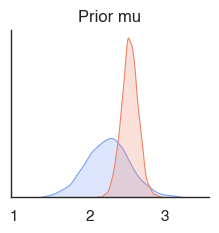

In [15]:
palette = sns.color_palette('coolwarm', 4)
palette = [palette[ix] for ix in [0, 3]]

evidence_sd = pd.concat((idata.posterior['risky_prior_mu_mu'].to_dataframe(), (idata.posterior['safe_prior_mu_mu'].to_dataframe())), axis=1)
evidence_sd.columns.name = 'parameter'
evidence_sd = evidence_sd.stack().to_frame('value')
evidence_sd['Option'] = evidence_sd.index.get_level_values('parameter').map({'risky_prior_mu_mu':'Risky', 'safe_prior_mu_mu':'Safe'})

fac = sns.FacetGrid(evidence_sd.reset_index(), hue='Option', palette=palette, aspect=1.1, height=2.5, hue_order=['Safe', 'Risky'])
fac.map(sns.kdeplot, 'value', fill=True)
fac.set(xlabel=None, ylabel=None, yticks=[])
plt.title('Prior mu')
# fac.add_legend()
# plt.legend(title='Option')

plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-3t2_prior_mu.pdf'), bbox_inches='tight')

In [16]:
((evidence_sd.xs('risky_prior_mu_mu', 0, 'parameter')['value'] - evidence_sd.xs('safe_prior_mu_mu', level='parameter')['value']) < 0.0).mean()

0.1645

## Prior SD

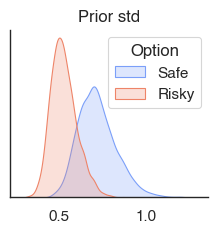

In [17]:
palette = sns.color_palette('coolwarm', 4)
palette = [palette[ix] for ix in [0, 3]]

evidence_sd = pd.concat((idata.posterior['risky_prior_std_mu'].to_dataframe(), (idata.posterior['safe_prior_std_mu'].to_dataframe())), axis=1)
evidence_sd.columns.name = 'parameter'
evidence_sd = evidence_sd.stack().to_frame('value')
evidence_sd['Option'] = evidence_sd.index.get_level_values('parameter').map({'risky_prior_std_mu':'Risky', 'safe_prior_std_mu':'Safe'})

fac = sns.FacetGrid(evidence_sd.reset_index(), hue='Option', palette=palette, aspect=1.1, height=2.5, hue_order=['Safe', 'Risky'])
fac.map(sns.kdeplot, 'value', fill=True)
fac.set(xlabel=None, ylabel=None, yticks=[])
plt.title('Prior std')
# fac.add_legend()
plt.legend(title='Option')
plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-3t2_prior_std.pdf'), bbox_inches='tight')

In [20]:
((evidence_sd.xs('risky_prior_std_mu', 0, 'parameter')['value'] - evidence_sd.xs('safe_prior_std_mu', level='parameter')['value']) > 0.0).mean()

0.01475

In [9]:
sns.color_palette('Spectral', 5)

[(0.9139561707035756, 0.36239907727797, 0.27935409457900806),
 (0.9934640522875817, 0.7477124183006535, 0.4352941176470587),
 (0.998077662437524, 0.9992310649750096, 0.7460207612456747),
 (0.7477124183006538, 0.8980392156862746, 0.6274509803921569),
 (0.3280276816608997, 0.6805074971164936, 0.6802768166089965)]

## individual differences

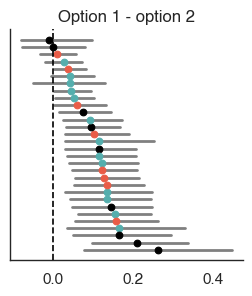

In [11]:
tmp = pd.concat((idata.posterior['n1_evidence_sd'].to_dataframe(), idata.posterior['n2_evidence_sd'].to_dataframe()), axis=1)

diff = (tmp['n1_evidence_sd'] - tmp['n2_evidence_sd']).to_frame('Evidence sd 1 - evidence sd 2')
# sns.catplot(data=diff, x='subject', y='Evidence sd 1 - evidence sd 2')

hdi = diff.groupby('subject').apply(lambda d: pd.Series(az.hdi(d.values[:, 0]), index=['low', 'high']))

mean = diff.groupby("subject").mean()
mean.columns = ['mean']

tmp = mean.join(hdi)
tmp = tmp.join(risk_preferences.xs(session, 0, 'session'))

order = mean.sort_values('mean').index.tolist()

def plot_hdi(data, *args, **kwargs):
    for ix, row in data.iterrows():
        x = order.index(ix)
        plt.scatter([row['mean']], [-x], marker='o', color=colors[row.risk_profile], zorder=5,)
        plt.plot([row['low'], row['high']], [-x, -x], color='gray', lw=2)

plot_hdi(tmp)
# plt.axis('off')
sns.despine()
plt.yticks([])
plt.axvline(0, c='k', ls='--', zorder=10)
plt.gcf().set_size_inches(3, 3)
plt.title('Option 1 - option 2')
plt.savefig('/data/ds-risk/derivatives/figures/3t2_evidence_sd_diff.pdf', bbox_inches='tight')

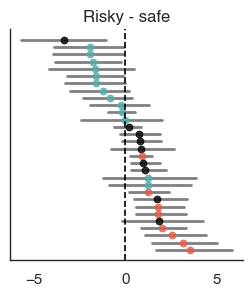

In [12]:
tmp = pd.concat((idata.posterior['risky_prior_mu'].to_dataframe(), idata.posterior['safe_prior_mu'].to_dataframe()), axis=1)

diff = (tmp['risky_prior_mu'] - tmp['safe_prior_mu']).to_frame('diff')
# sns.catplot(data=diff, x='subject', y='Evidence sd 1 - evidence sd 2')

hdi = diff.groupby('subject').apply(lambda d: pd.Series(az.hdi(d.values[:, 0]), index=['low', 'high']))

mean = diff.groupby("subject").mean()
mean.columns = ['mean']

tmp = mean.join(hdi)

tmp = tmp.join(risk_preferences.xs(session, 0, 'session'))

order = mean.sort_values('mean').index.tolist()

def plot_hdi(data, *args, **kwargs):
    for ix, row in data.iterrows():
        x = order.index(ix)
        plt.scatter([row['mean']], [-x], marker='o', color=colors[row.risk_profile], zorder=5, alpha=.8)
        plt.plot([row['low'], row['high']], [-x, -x], color='gray', lw=2)

plot_hdi(tmp)
# plt.axis('off')
sns.despine()
plt.yticks([])
plt.axvline(0, c='k', ls='--', zorder=10)
plt.gcf().set_size_inches(3, 3)
plt.title('Risky - safe')

plt.savefig('/data/ds-risk/derivatives/figures/3t2_risky_prior_mu_diff.pdf', bbox_inches='tight')

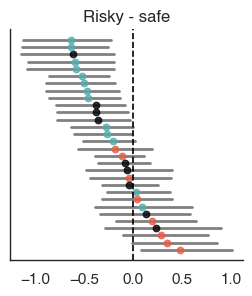

In [13]:
tmp = pd.concat((idata.posterior['risky_prior_std'].to_dataframe(), idata.posterior['safe_prior_std'].to_dataframe()), axis=1)

diff = (tmp['risky_prior_std'] - tmp['safe_prior_std']).to_frame('diff')
# sns.catplot(data=diff, x='subject', y='Evidence sd 1 - evidence sd 2')

hdi = diff.groupby('subject').apply(lambda d: pd.Series(az.hdi(d.values[:, 0]), index=['low', 'high']))

mean = diff.groupby("subject").mean()
mean.columns = ['mean']

tmp = mean.join(hdi)
tmp = tmp.join(risk_preferences.xs(session, 0, 'session'))

order = mean.sort_values('mean').index.tolist()

def plot_hdi(data, *args, **kwargs):
    for ix, row in data.iterrows():
        x = order.index(ix)
        plt.scatter([row['mean']], [-x], marker='o', color=colors[row.risk_profile], zorder=5, alpha=.8)
        plt.plot([row['low'], row['high']], [-x, -x], color='gray', lw=2)

plot_hdi(tmp)
# plt.axis('off')
sns.despine()
plt.yticks([])
plt.axvline(0, c='k', ls='--', zorder=10)
plt.gcf().set_size_inches(3, 3)
plt.gcf().set_size_inches(3, 3)
plt.title('Risky - safe')

plt.savefig('/data/ds-risk/derivatives/figures/3t2_risky_prior_std_diff.pdf', bbox_inches='tight')

# Legend

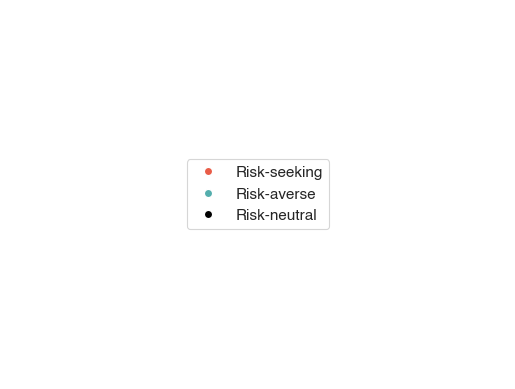

In [14]:
from matplotlib.lines import Line2D

fig = plt.gcf()

legend_elements = [Line2D([0], [0], markerfacecolor=colors['risk-seeking'], marker='o', color='w', label='Risk-seeking', markersize=6),
                   Line2D([0], [0], markerfacecolor=colors['risk-averse'], marker='o', color='w', label='Risk-averse', markersize=6),
                   Line2D([0], [0], markerfacecolor=colors['risk-neutral'], marker='o', color='w', label='Risk-neutral', markersize=6),]


legend = plt.legend(handles=legend_elements, loc='center')
plt.axis('off')

bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# fig.savefig(filename, dpi="figure", bbox_inches=bbox)

plt.savefig('/data/ds-risk/derivatives/figures/risky_type_legend.pdf', bbox_inches=bbox)

# 7T

In [21]:
session = '7t2'


idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', f'ses-{session}_model-1_trace.netcdf'))

## Evidence sd

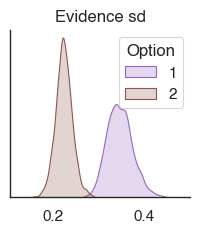

In [22]:
evidence_sd = pd.concat((idata.posterior['n1_evidence_sd_mu'].to_dataframe(), (idata.posterior['n2_evidence_sd_mu'].to_dataframe())), axis=1)
evidence_sd.columns.name = 'parameter'
evidence_sd = evidence_sd.stack().to_frame('value')
evidence_sd['Option'] = evidence_sd.index.get_level_values('parameter').map({'n1_evidence_sd_mu':1, 'n2_evidence_sd_mu':2})

fac = sns.FacetGrid(evidence_sd.reset_index(), hue='Option', palette=sns.color_palette()[4:], aspect=1.1, height=2.5)
fac.map(sns.kdeplot, 'value', fill=True)
fac.set(xlabel=None, ylabel=None, yticks=[])
plt.title('Evidence sd')
# fac.add_legend()
plt.legend(title='Option')

plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-7t2_evidence_sd.pdf'), bbox_inches='tight')

In [23]:
(n1_evidence_sd.iloc[:, 0] - n2_evidence_sd.iloc[:, 0] < 0.0).mean()

0.0664

## Prior mu

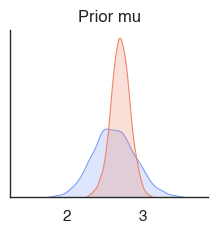

In [24]:
palette = sns.color_palette('coolwarm', 4)
palette = [palette[ix] for ix in [0, 3]]

evidence_sd = pd.concat((idata.posterior['risky_prior_mu_mu'].to_dataframe(), (idata.posterior['safe_prior_mu_mu'].to_dataframe())), axis=1)
evidence_sd.columns.name = 'parameter'
evidence_sd = evidence_sd.stack().to_frame('value')
evidence_sd['Option'] = evidence_sd.index.get_level_values('parameter').map({'risky_prior_mu_mu':'Risky', 'safe_prior_mu_mu':'Safe'})

fac = sns.FacetGrid(evidence_sd.reset_index(), hue='Option', palette=palette, aspect=1.1, height=2.5, hue_order=['Safe', 'Risky'])
fac.map(sns.kdeplot, 'value', fill=True)
fac.set(xlabel=None, ylabel=None, yticks=[])
plt.title('Prior mu')
# fac.add_legend()
# plt.legend(title='Option')

plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-7t2_prior_mu.pdf'), bbox_inches='tight')

In [25]:
((evidence_sd.xs('risky_prior_mu_mu', 0, 'parameter')['value'] - evidence_sd.xs('safe_prior_mu_mu', level='parameter')['value']) < 0.0).mean()

0.373

## Prior sd

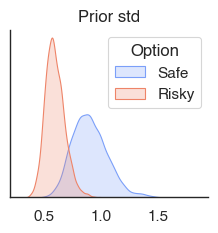

In [26]:
palette = sns.color_palette('coolwarm', 4)
palette = [palette[ix] for ix in [0, 3]]

evidence_sd = pd.concat((idata.posterior['risky_prior_std_mu'].to_dataframe(), (idata.posterior['safe_prior_std_mu'].to_dataframe())), axis=1)
evidence_sd.columns.name = 'parameter'
evidence_sd = evidence_sd.stack().to_frame('value')
evidence_sd['Option'] = evidence_sd.index.get_level_values('parameter').map({'risky_prior_std_mu':'Risky', 'safe_prior_std_mu':'Safe'})

fac = sns.FacetGrid(evidence_sd.reset_index(), hue='Option', palette=palette, aspect=1.1, height=2.5, hue_order=['Safe', 'Risky'])
fac.map(sns.kdeplot, 'value', fill=True)
fac.set(xlabel=None, ylabel=None, yticks=[])
plt.title('Prior std')
# fac.add_legend()
plt.legend(title='Option')
plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'ses-7t2_prior_std.pdf'), bbox_inches='tight')

In [27]:
((evidence_sd.xs('risky_prior_std_mu', 0, 'parameter')['value'] - evidence_sd.xs('safe_prior_std_mu', level='parameter')['value']) > 0.0).mean()

0.00425

## Individual differences

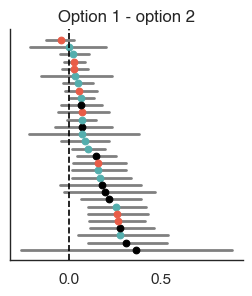

In [19]:
tmp = pd.concat((idata.posterior['n1_evidence_sd'].to_dataframe(), idata.posterior['n2_evidence_sd'].to_dataframe()), axis=1)

diff = (tmp['n1_evidence_sd'] - tmp['n2_evidence_sd']).to_frame('Evidence sd 1 - evidence sd 2')
# sns.catplot(data=diff, x='subject', y='Evidence sd 1 - evidence sd 2')

hdi = diff.groupby('subject').apply(lambda d: pd.Series(az.hdi(d.values[:, 0]), index=['low', 'high']))

mean = diff.groupby("subject").mean()
mean.columns = ['mean']

tmp = mean.join(hdi)
tmp = tmp.join(risk_preferences.xs(session, 0, 'session'))

order = mean.sort_values('mean').index.tolist()

def plot_hdi(data, *args, **kwargs):
    for ix, row in data.iterrows():
        x = order.index(ix)
        plt.scatter([row['mean']], [-x], marker='o', color=colors[row.risk_profile], zorder=5,)
        plt.plot([row['low'], row['high']], [-x, -x], color='gray', lw=2)

plot_hdi(tmp)
# plt.axis('off')
sns.despine()
plt.yticks([])
plt.axvline(0, c='k', ls='--', zorder=10)
plt.gcf().set_size_inches(3, 3)
plt.title('Option 1 - option 2')
plt.savefig('/data/ds-risk/derivatives/figures/7t2_evidence_sd_diff.pdf', bbox_inches='tight')

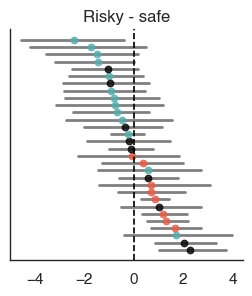

In [20]:
tmp = pd.concat((idata.posterior['risky_prior_mu'].to_dataframe(), idata.posterior['safe_prior_mu'].to_dataframe()), axis=1)

diff = (tmp['risky_prior_mu'] - tmp['safe_prior_mu']).to_frame('diff')
# sns.catplot(data=diff, x='subject', y='Evidence sd 1 - evidence sd 2')

hdi = diff.groupby('subject').apply(lambda d: pd.Series(az.hdi(d.values[:, 0]), index=['low', 'high']))

mean = diff.groupby("subject").mean()
mean.columns = ['mean']

tmp = mean.join(hdi)

tmp = tmp.join(risk_preferences.xs(session, 0, 'session'))

order = mean.sort_values('mean').index.tolist()

def plot_hdi(data, *args, **kwargs):
    for ix, row in data.iterrows():
        x = order.index(ix)
        plt.scatter([row['mean']], [-x], marker='o', color=colors[row.risk_profile], zorder=5, alpha=.8)
        plt.plot([row['low'], row['high']], [-x, -x], color='gray', lw=2)

plot_hdi(tmp)
# plt.axis('off')
sns.despine()
plt.yticks([])
plt.axvline(0, c='k', ls='--', zorder=10)
plt.gcf().set_size_inches(3, 3)
plt.title('Risky - safe')

plt.savefig('/data/ds-risk/derivatives/figures/7t2_risky_prior_mu_diff.pdf', bbox_inches='tight')

In [5]:
tmp = pd.concat((idata.posterior['risky_prior_std'].to_dataframe(), idata.posterior['safe_prior_std'].to_dataframe()), axis=1)

diff = (tmp['risky_prior_std'] - tmp['safe_prior_std']).to_frame('diff')
# sns.catplot(data=diff, x='subject', y='Evidence sd 1 - evidence sd 2')

hdi = diff.groupby('subject').apply(lambda d: pd.Series(az.hdi(d.values[:, 0]), index=['low', 'high']))

mean = diff.groupby("subject").mean()
mean.columns = ['mean']

tmp = mean.join(hdi)
tmp = tmp.join(risk_preferences.xs(session, 0, 'session'))

order = mean.sort_values('mean').index.tolist()

def plot_hdi(data, *args, **kwargs):
    for ix, row in data.iterrows():
        x = order.index(ix)
        plt.scatter([row['mean']], [-x], marker='o', color=colors[row.risk_profile], zorder=5, alpha=.8)
        plt.plot([row['low'], row['high']], [-x, -x], color='gray', lw=2)

plot_hdi(tmp)
# plt.axis('off')
sns.despine()
plt.yticks([])
plt.axvline(0, c='k', ls='--', zorder=10)
plt.gcf().set_size_inches(3, 3)
plt.gcf().set_size_inches(3, 3)
plt.title('Risky - safe')

plt.savefig('/data/ds-risk/derivatives/figures/7t2_risky_prior_std_diff.pdf', bbox_inches='tight')

NameError: name 'idata' is not defined

# Combined data

In [28]:
risk_preferences = pd.read_csv(op.join(bids_folder, 'derivatives', 'cogmodels', 'simple_risk_preference.tsv'), index_col=[0, 1], sep='\t', dtype={'subject':str})
from bauer.utils.math import softplus_np
idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', f'model-12_trace.netcdf'))

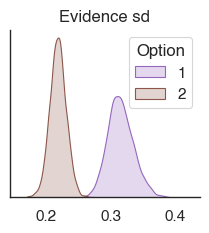

In [29]:
n1_evidence_sd = idata.posterior['n1_evidence_sd_mu'].to_dataframe()
n2_evidence_sd = idata.posterior['n2_evidence_sd_mu'].to_dataframe()
n1_evidence_sd = softplus_np(n1_evidence_sd.xs('Intercept', 0, -1) + 0.5* n1_evidence_sd.xs('session[T.7t2]', 0, -1))
n2_evidence_sd = softplus_np(n2_evidence_sd.xs('Intercept', 0, -1) + 0.5* n2_evidence_sd.xs('session[T.7t2]', 0, -1))
evidence_sd = pd.concat((n1_evidence_sd, n2_evidence_sd), axis=1)
evidence_sd.columns.name = 'parameter'
evidence_sd = evidence_sd.stack().to_frame('value')
evidence_sd['Option'] = evidence_sd.index.get_level_values('parameter').map({'n1_evidence_sd_mu':1, 'n2_evidence_sd_mu':2})

fac = sns.FacetGrid(evidence_sd.reset_index(), hue='Option', palette=sns.color_palette()[4:], aspect=1.1, height=2.5)
fac.map(sns.kdeplot, 'value', fill=True)
fac.set(xlabel=None, ylabel=None, yticks=[])
plt.title('Evidence sd')
# fac.add_legend()
plt.legend(title='Option')

plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'evidence_sd.pdf'), bbox_inches='tight')

In [30]:
(n1_evidence_sd.iloc[:, 0] - n2_evidence_sd.iloc[:, 0] < 0.0).mean()

0.0

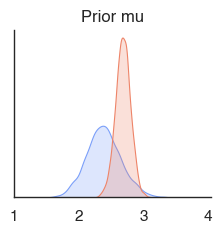

In [31]:
palette = sns.color_palette('coolwarm', 4)
palette = [palette[ix] for ix in [0, 3]]

risky_prior_mu = idata.posterior['risky_prior_mu_mu'].to_dataframe()
safe_prior_mu = idata.posterior['safe_prior_mu_mu'].to_dataframe()

risky_prior_mu = softplus_np(risky_prior_mu.xs('Intercept', 0, -1) + 0.5 * risky_prior_mu.xs('session[T.7t2]', 0, -1))
safe_prior_mu = softplus_np(safe_prior_mu.xs('Intercept', 0, -1) + 0.5* safe_prior_mu.xs('session[T.7t2]', 0, -1))
prior_mu = pd.concat((risky_prior_mu, safe_prior_mu), axis=1)
prior_mu.columns.name = 'parameter'
prior_mu = prior_mu.stack().to_frame('value')
prior_mu['Option'] = prior_mu.index.get_level_values('parameter').map({'risky_prior_mu_mu':'Risky', 'safe_prior_mu_mu':'Safe'})

fac = sns.FacetGrid(prior_mu.reset_index(), hue='Option', palette=palette, aspect=1.1, height=2.5, hue_order=['Safe', 'Risky'])
fac.map(sns.kdeplot, 'value', fill=True)
fac.set(xlabel=None, ylabel=None, yticks=[])
plt.title('Prior mu')
# fac.add_legend()
# plt.legend(title='Option')

plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'prior_mu.pdf'), bbox_inches='tight')

In [32]:
((prior_mu.xs('risky_prior_mu_mu', 0, 'parameter')['value'] - prior_mu.xs('safe_prior_mu_mu', level='parameter')['value']) < 0.0).mean()

0.13216666666666665

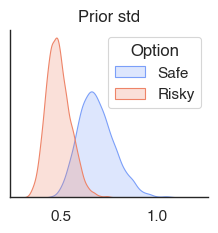

In [33]:
palette = sns.color_palette('coolwarm', 4)
palette = [palette[ix] for ix in [0, 3]]

risky_prior_std = idata.posterior['risky_prior_std_mu'].to_dataframe()
safe_prior_std = idata.posterior['safe_prior_std_mu'].to_dataframe()

risky_prior_std = softplus_np(risky_prior_std.xs('Intercept', 0, -1) + 0.5 * risky_prior_std.xs('session[T.7t2]', 0, -1))
safe_prior_std = softplus_np(safe_prior_std.xs('Intercept', 0, -1) + 0.5* safe_prior_std.xs('session[T.7t2]', 0, -1))
prior_std = pd.concat((risky_prior_std, safe_prior_std), axis=1)
prior_std.columns.name = 'parameter'
prior_std = prior_std.stack().to_frame('value')
prior_std['Option'] = prior_std.index.get_level_values('parameter').map({'risky_prior_std_mu':'Risky', 'safe_prior_std_mu':'Safe'})

fac = sns.FacetGrid(prior_std.reset_index(), hue='Option', palette=palette, aspect=1.1, height=2.5, hue_order=['Safe', 'Risky'])
fac.map(sns.kdeplot, 'value', fill=True)
fac.set(xlabel=None, ylabel=None, yticks=[])
plt.title('Prior std')
# fac.add_legend()
plt.legend(title='Option')

plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'prior_std.pdf'), bbox_inches='tight')

In [34]:
((prior_std.xs('risky_prior_std_mu', 0, 'parameter')['value'] - prior_std.xs('safe_prior_std_mu', level='parameter')['value']) > 0.0).mean()

0.0033333333333333335

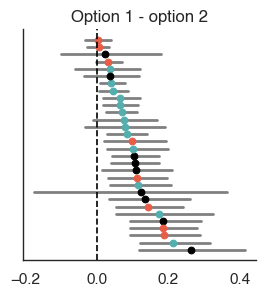

In [8]:
n1_evidence_sd = idata.posterior['n1_evidence_sd'].to_dataframe()
n2_evidence_sd = idata.posterior['n2_evidence_sd'].to_dataframe()
n1_evidence_sd = softplus_np(n1_evidence_sd.xs('Intercept', 0, -1) + 0.5* n1_evidence_sd.xs('session[T.7t2]', 0, -1))
n2_evidence_sd = softplus_np(n2_evidence_sd.xs('Intercept', 0, -1) + 0.5* n2_evidence_sd.xs('session[T.7t2]', 0, -1))

tmp = pd.concat((n1_evidence_sd, n2_evidence_sd), axis=1)

diff = (tmp['n1_evidence_sd'] - tmp['n2_evidence_sd']).to_frame('Evidence sd 1 - evidence sd 2')
# sns.catplot(data=diff, x='subject', y='Evidence sd 1 - evidence sd 2')

hdi = diff.groupby('subject').apply(lambda d: pd.Series(az.hdi(d.values[:, 0]), index=['low', 'high']))

mean = diff.groupby("subject").mean()
mean.columns = ['mean']

tmp = mean.join(hdi)
tmp = tmp.join(risk_preferences.xs('both', 0, 'session'))

order = mean.sort_values('mean').index.tolist()

def plot_hdi(data, *args, **kwargs):
    for ix, row in data.iterrows():
        x = order.index(ix)
        plt.scatter([row['mean']], [-x], marker='o', color=colors[row.risk_profile], zorder=5,)
        plt.plot([row['low'], row['high']], [-x, -x], color='gray', lw=2)

plot_hdi(tmp)
# plt.axis('off')
sns.despine()
plt.yticks([])
plt.axvline(0, c='k', ls='--', zorder=10)
plt.gcf().set_size_inches(3, 3)
plt.title('Option 1 - option 2')
plt.savefig('/data/ds-risk/derivatives/figures/evidence_sd_diff.pdf', bbox_inches='tight')

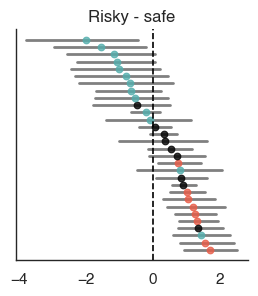

In [9]:

risky_prior_mu = idata.posterior['risky_prior_mu'].to_dataframe()
safe_prior_mu = idata.posterior['safe_prior_mu'].to_dataframe()

risky_prior_mu = softplus_np(risky_prior_mu.xs('Intercept', 0, -1) + 0.5 * risky_prior_mu.xs('session[T.7t2]', 0, -1))
safe_prior_mu = softplus_np(safe_prior_mu.xs('Intercept', 0, -1) + 0.5* safe_prior_mu.xs('session[T.7t2]', 0, -1))

tmp = pd.concat((risky_prior_mu, safe_prior_mu), axis=1)

diff = (tmp['risky_prior_mu'] - tmp['safe_prior_mu']).to_frame('diff')
# sns.catplot(data=diff, x='subject', y='Evidence sd 1 - evidence sd 2')

hdi = diff.groupby('subject').apply(lambda d: pd.Series(az.hdi(d.values[:, 0]), index=['low', 'high']))

mean = diff.groupby("subject").mean()
mean.columns = ['mean']

tmp = mean.join(hdi)

tmp = tmp.join(risk_preferences.xs(session, 0, 'session'))

order = mean.sort_values('mean').index.tolist()

def plot_hdi(data, *args, **kwargs):
    for ix, row in data.iterrows():
        x = order.index(ix)
        plt.scatter([row['mean']], [-x], marker='o', color=colors[row.risk_profile], zorder=5, alpha=.8)
        plt.plot([row['low'], row['high']], [-x, -x], color='gray', lw=2)

plot_hdi(tmp)
# plt.axis('off')
sns.despine()
plt.yticks([])
plt.axvline(0, c='k', ls='--', zorder=10)
plt.gcf().set_size_inches(3, 3)
plt.title('Risky - safe')

plt.savefig('/data/ds-risk/derivatives/figures/risky_prior_mu_diff.pdf', bbox_inches='tight')

In [10]:
(tmp['low'] > 0.0).sum()

12

In [11]:
(tmp['high'] < 0.0).sum()

2

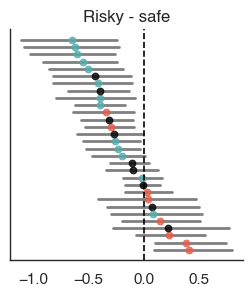

In [28]:
risky_prior_std = idata.posterior['risky_prior_std'].to_dataframe()
safe_prior_std = idata.posterior['safe_prior_std'].to_dataframe()

risky_prior_std = softplus_np(risky_prior_std.xs('Intercept', 0, -1) + 0.5 * risky_prior_std.xs('session[T.7t2]', 0, -1))
safe_prior_std = softplus_np(safe_prior_std.xs('Intercept', 0, -1) + 0.5* safe_prior_std.xs('session[T.7t2]', 0, -1))

tmp = pd.concat((risky_prior_std, safe_prior_std), axis=1)

diff = (tmp['risky_prior_std'] - tmp['safe_prior_std']).to_frame('diff')
# sns.catplot(data=diff, x='subject', y='Evidence sd 1 - evidence sd 2')

hdi = diff.groupby('subject').apply(lambda d: pd.Series(az.hdi(d.values[:, 0]), index=['low', 'high']))

mean = diff.groupby("subject").mean()
mean.columns = ['mean']

tmp = mean.join(hdi)
tmp = tmp.join(risk_preferences.xs(session, 0, 'session'))

order = mean.sort_values('mean').index.tolist()

def plot_hdi(data, *args, **kwargs):
    for ix, row in data.iterrows():
        x = order.index(ix)
        plt.scatter([row['mean']], [-x], marker='o', color=colors[row.risk_profile], zorder=5, alpha=.8)
        plt.plot([row['low'], row['high']], [-x, -x], color='gray', lw=2)

plot_hdi(tmp)
# plt.axis('off')
sns.despine()
plt.yticks([])
plt.axvline(0, c='k', ls='--', zorder=10)
plt.gcf().set_size_inches(3, 3)
plt.gcf().set_size_inches(3, 3)
plt.title('Risky - safe')

plt.savefig('/data/ds-risk/derivatives/figures/risky_prior_std_diff.pdf', bbox_inches='tight')

In [40]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [36]:
from risk_experiment.utils.data import get_all_behavior

In [37]:
df = get_all_behavior(bids_folder=bids_folder)

100%|██████████| 30/30 [00:02<00:00, 13.39it/s]


In [44]:
import numpy as np
df['log(n_safe)'] = np.log(df['n_safe'])
df['log(n_risky)'] = np.log(df['n_risky'])

In [49]:
df.groupby(['subject', 'session'])[['log(n_safe)', 'log(n_risky)']].std().describe()

,log(n_safe),log(n_risky)
count,6.000000e+01,60.000000
mean,5.919718e-01,0.665980
std,2.366201e-16,0.035339
min,5.919718e-01,0.600267
25%,5.919718e-01,0.639516
50%,5.919718e-01,0.656933
75%,5.919718e-01,0.681173
max,5.919718e-01,0.752461


In [66]:
idata = az.from_netcdf('/data/ds-risk/derivatives/cogmodels/ses-3t2_model-22_trace.netcdf')
risky_prior_std_mu = idata.posterior['risky_prior_std_mu'].to_dataframe()
safe_prior_std_mu = idata.posterior['safe_prior_std_mu'].to_dataframe()

((risky_prior_std_mu.iloc[:, 0] - safe_prior_std_mu.iloc[:, 0]) > 0.0).mean()

0.3925

In [67]:
idata = az.from_netcdf('/data/ds-risk/derivatives/cogmodels/ses-7t2_model-22_trace.netcdf')
risky_prior_std_mu = idata.posterior['risky_prior_std_mu'].to_dataframe()
safe_prior_std_mu = idata.posterior['safe_prior_std_mu'].to_dataframe()

((risky_prior_std_mu.iloc[:, 0] - safe_prior_std_mu.iloc[:, 0]) > 0.0).mean()

0.10866666666666666

In [65]:
idata = az.from_netcdf('/data/ds-risk/derivatives/cogmodels/model-222_trace.netcdf')
risky_prior_std_mu = idata.posterior['risky_prior_std_mu'].to_dataframe()
safe_prior_std_mu = idata.posterior['safe_prior_std_mu'].to_dataframe()

((risky_prior_std_mu.iloc[:, 0] - safe_prior_std_mu.iloc[:, 0]) > 0.0).mean()

0.10675

In [5]:
from risk_experiment.cogmodels.fit_probit import build_model, get_data
from risk_experiment.cogmodels.utils import get_fake_data, extract_intercept_gamma

In [6]:
def load(model_label, session, bids_folder='/data/ds-risk'):
    df = get_data(model_label, session, bids_folder)
    model = build_model(model_label, df, session, bids_folder)
    if session is None:
        idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/model-{model_label}_trace.netcdf')
    else:
        idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/model-{model_label}_ses-{session}_trace.netcdf')

    return df, model, idata

def get_hdi(x):
    return tuple(az.hdi(x.values))

100%|██████████| 30/30 [00:01<00:00, 26.69it/s]


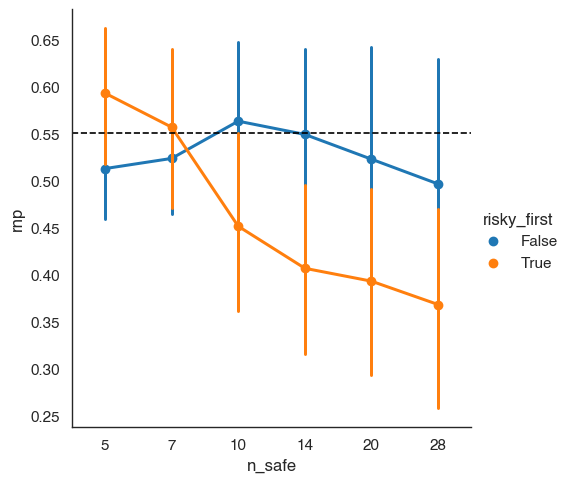

In [7]:
df, model, idata = load('probit_full', '3t2')
intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

sns.catplot(rnp.reset_index(), x='n_safe', y='rnp', hue='risky_first', errorbar=get_hdi, kind='point')
plt.axhline(0.55, c='k', ls='--')

In [8]:
rnp.groupby(['n_safe', 'risky_first'])['rnp'].apply(lambda x: (x > 0.55).mean(0))

n_safe  risky_first
5       False          0.08525
        True           0.87400
7       False          0.19425
        True           0.56475
10      False          0.60925
        True           0.01900
14      False          0.49675
        True           0.00100
20      False          0.33475
        True           0.00125
28      False          0.21250
        True           0.00075
Name: rnp, dtype: float64

100%|██████████| 30/30 [00:01<00:00, 25.40it/s]


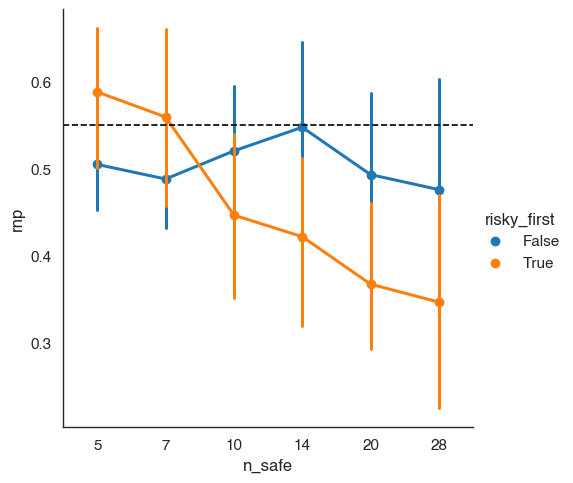

In [9]:
df, model, idata = load('probit_full', '7t2')
intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

sns.catplot(rnp.reset_index(), x='n_safe', y='rnp', hue='risky_first', errorbar=get_hdi, kind='point')
plt.axhline(0.55, c='k', ls='--')

In [10]:
rnp.groupby(['n_safe', 'risky_first'])['rnp'].apply(lambda x: (x > 0.55).mean(0))

n_safe  risky_first
5       False          0.05150
        True           0.81875
7       False          0.02425
        True           0.57025
10      False          0.23075
        True           0.01825
14      False          0.47700
        True           0.00675
20      False          0.13975
        True           0.00000
28      False          0.13525
        True           0.00150
Name: rnp, dtype: float64

100%|██████████| 30/30 [00:01<00:00, 17.88it/s]


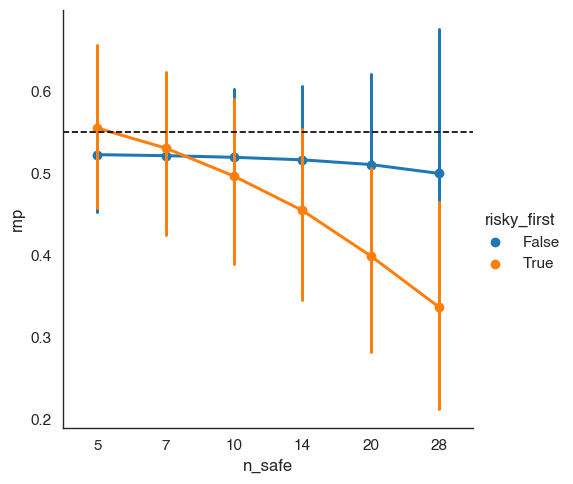

In [11]:
df, model, idata = load('probit_full_session', None)
intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

sns.catplot(rnp.reset_index(), x='n_safe', y='rnp', hue='risky_first', errorbar=get_hdi, kind='point')
plt.axhline(0.55, c='k', ls='--')